In [10]:
import polars as pl
import geopandas as gpd
from pathlib import Path
import folium
import pandas as pd
import numpy as np
from shapely import Point
from itertools import product

from matplotlib import pyplot as plt

write_outputs = False

# Data Load

First, we read in the shapefile for the gridcell covariates.

We will be using EPSG 3174 for the Great Lakes coordinate system, followed by EPSG:4326 for plotting.

See https://epsg.io/3174 and https://epsg.io/4326

try epsg 2163 - clear outputs

In [6]:
bat_covars = gpd.read_file("data/data/NABat_grid_covariates/NABat_grid_covariates.shp")
stations = pd.read_excel("data/data/USFWS_Bat_Acoustic_Data/Metadata.xlsx", sheet_name='AcousticSites')
pass_counts = pd.read_excel("data/data/USFWS_Bat_Acoustic_Data/NightlyPassCounts.xlsx")
water_bodies = gpd.read_file("data/data/USA_Detailed_Water_Bodies/USA_Detailed_Water_Bodies.shp")
lakes = gpd.read_file("data/data/rivers_and_lakes_shapefile/NA_Lakes_and_Rivers/data/lakes_p/northamerica_lakes_cec_2023.shp")
rivers = gpd.read_file("data/data/rivers_and_lakes_shapefile/NA_Lakes_and_Rivers/data/rivers_l/northamerica_rivers_cec_2023.shp")


# Water Bodies

Using three sources for water polygons, we create a dataframe of all water bodies together.

<Axes: >

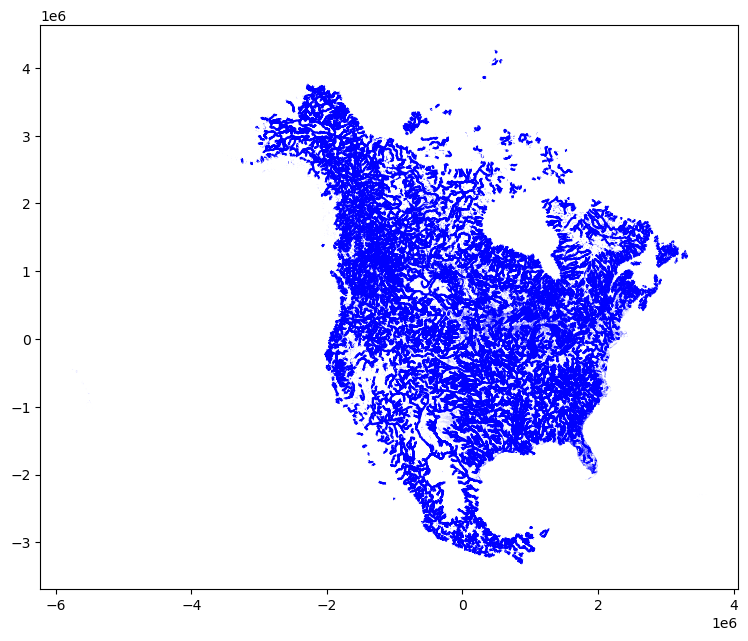

In [ ]:
lakes = lakes.to_crs(epsg=2163)
rivers = rivers.to_crs(epsg=2163)
water_bodies = water_bodies.to_crs(epsg=2163)


all_water_bodies = gpd.GeoDataFrame(pd.concat([
    water_bodies,
    lakes,
    rivers
], axis=0, ignore_index=True), geometry='geometry')

all_water_bodies["NAME"] = all_water_bodies["NAME"].combine_first(all_water_bodies["NameEn"]).combine_first(all_water_bodies["NameEs"]).combine_first(all_water_bodies["NameFr"]).fillna("Unknown")
all_water_bodies.head()

In [ ]:
all_water_bodies.plot(figsize=(9, 9), color="blue")

In [11]:
# write out the data for later, if desired
if write_outputs:
    all_water_bodies.to_csv("data/data/all_water_bodies.csv", index=False)

# Stations

Find the nearest water bodies for each station.

In [12]:
stations["geometry"] = gpd.points_from_xy(stations["Long"], stations["Lat"], crs="EPSG:4326").to_crs(epsg=2163)
stations = gpd.GeoDataFrame(stations, geometry='geometry')

Now, merge the two datasets together.

<Axes: >

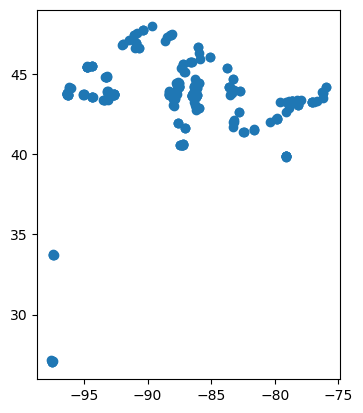

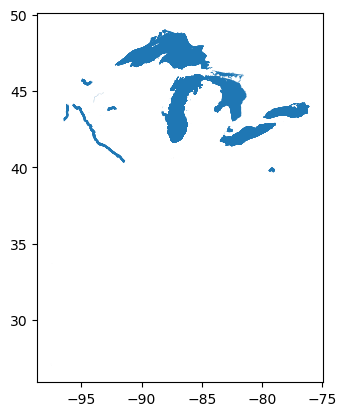

In [13]:
station_plus_water = (
    gpd.sjoin_nearest(
        stations, all_water_bodies, how="left", distance_col="dist_to_water", rsuffix="_water"
    )
    .sort_values("dist_to_water", ascending=False)
    .groupby("AcousticSite")
    .nth(0)
)

nearest_water = all_water_bodies.loc[station_plus_water["index__water"]]

# station_plus_water = station_plus_water.set_geometry("geometry")

station_plus_water = station_plus_water.to_crs("EPSG:4326")
station_plus_water.plot()

water_geom = nearest_water[["NAME", "geometry"]].to_crs("EPSG:4326")
water_geom.plot()


In [14]:
if write_outputs:
    station_plus_water.to_csv("./station_plus_water.csv", index=False)

In [15]:
if write_outputs:
    m = folium.Map(zoom_start=4, location=[38.5, -90.0])
    plotted_geoms = set()
    i = 0
    for (row, water_geo) in zip(station_plus_water.iterrows(), water_geom.iterrows()):

        # print(i)
        _, r = row
        _, w = water_geo
        poly_dat = gpd.GeoSeries(r["geometry"]).to_json()

        water_dat = gpd.GeoSeries(w["geometry"]).to_json()
        geo_j = folium.GeoJson(data=poly_dat)
        water_j = folium.GeoJson(data=water_dat)
        info = pd.DataFrame(
            r[["AcousticSite", 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, "dist_to_water", "NAME"]],
        ).to_html()

        w_info = w["NAME"]

        folium.Popup(info).add_to(geo_j)
        folium.Popup(w_info).add_to(water_j)

        geo_j.add_to(m)
        if water_dat not in plotted_geoms:
            water_j.add_to(m)
            plotted_geoms.add(water_dat)

        i += 1
        if i % 50 == 0:
            print(f"{i} ({i/len(station_plus_water)*100:.0f}%)")
        

    m.save("bat_maps_distance.html")

In [16]:
station_plus_water = station_plus_water.reset_index()
station_plus_water["water_geom"] = water_geom.reset_index()["geometry"]

In [17]:
water_body_size = (
    station_plus_water["SQKM"]
    .combine_first(station_plus_water["AreaSqKm"])
    .combine_first(station_plus_water["LengthKm"])
)


station_water_metadata = (
    station_plus_water.assign(water_size=water_body_size)[
        [
            "AcousticSite",
            "Lat",
            "Long",
            "geometry",
            2010,
            2011,
            2012,
            2013,
            2014,
            2015,
            2016,
            2017,
            2018,
            "EPTFUS",
            "LASBOR",
            "LASCIN",
            "LASNOC",
            "MYOLUC",
            "MYOSEP",
            "PERSUB",
            "MYOLEI",
            "MYOSOD",
            "NYCHUM",
            "CORRAF",
            "ANTPAL",
            "LASINT",
            "TADBRA",
            "dist_to_water",
            "NAME",
            "water_size",
            "water_geom",
        ]
    ]
    .rename(
        {
            "NAME": "water_name",
            2010: "nights_2010",
            2011: "nights_2011",
            2012: "nights_2012",
            2013: "nights_2013",
            2014: "nights_2014",
            2015: "nights_2015",
            2016: "nights_2016",
            2017: "nights_2017",
            2018: "nights_2018",
        },
        axis=1,
    )
)

station_water_metadata.to_csv("./data/data/stations_with_water.csv", index=True)
station_water_metadata.head()

,AcousticSite,Lat,Long,geometry,nights_2010,nights_2011,nights_2012,nights_2013,nights_2014,nights_2015,...,MYOSOD,NYCHUM,CORRAF,ANTPAL,LASINT,TADBRA,dist_to_water,water_name,water_size,water_geom
0,TG1500,43.7328,-96.3149,POINT (-96.3149 43.7328),95,171,0,0,0,0,...,no,no,no,no,no,no,10090.608912,Unknown,0.05,"POLYGON ((-96.18927 43.72289, -96.18873 43.722..."
1,GM161B,43.6729,-92.6694,POINT (-92.6694 43.6729),0,0,76,0,0,0,...,no,no,no,no,no,no,9690.585468,Unknown,0.07,"POLYGON ((-92.55179 43.70169, -92.55028 43.701..."
2,GM161C,43.6775,-92.6694,POINT (-92.6694 43.6775),0,0,84,0,0,0,...,no,no,no,no,no,no,9540.079986,Unknown,0.07,"POLYGON ((-92.55179 43.70169, -92.55028 43.701..."
3,GM161A,43.6729,-92.6668,POINT (-92.6668 43.6729),0,0,88,0,0,0,...,no,no,no,no,no,no,9492.670962,Unknown,0.07,"POLYGON ((-92.55179 43.70169, -92.55028 43.701..."
4,TG5K,43.7288,-96.3522,POINT (-96.3522 43.7288),83,0,0,0,0,0,...,no,no,no,no,no,no,9181.132346,Unknown,0.02,"POLYGON ((-96.42465 43.66357, -96.42516 43.664..."


In [18]:
bat_counts = pl.read_excel("data/data/USFWS_Bat_Acoustic_Data/NightlyPassCounts.xlsx")
bat_counts.columns

['AcousticSite',
 'NightOf',
 'ALL',
 'EPTFUS',
 'LASBOR',
 'LASCIN',
 'LASNOC',
 'MYOLUC',
 'MYOSEP',
 'PERSUB',
 'MYOLEI',
 'MYOSOD',
 'NYCHUM',
 'CORRAF',
 'ANTPAL',
 'LASINT',
 'TADBRA']

In [19]:
bat_count_agg = (
    bat_counts.group_by_dynamic("NightOf", every="1y", group_by="AcousticSite")
    .agg(
        pl.col(
            "ALL",
            "EPTFUS",
            "LASBOR",
            "LASCIN",
            "LASNOC",
            "MYOLUC",
            "MYOSEP",
            "PERSUB",
            "MYOLEI",
            "MYOSOD",
            "NYCHUM",
            "CORRAF",
            "ANTPAL",
            "LASINT",
            "TADBRA",
        ).sum()
    )
    .with_columns(pl.col("NightOf").dt.year().alias("Year"))
    .to_pandas()
)
bat_count_agg

,AcousticSite,NightOf,ALL,EPTFUS,LASBOR,LASCIN,LASNOC,MYOLUC,MYOSEP,PERSUB,MYOLEI,MYOSOD,NYCHUM,CORRAF,ANTPAL,LASINT,TADBRA,Year
0,B1,2010-01-01,751,4,77,77,120,368,2,38,0,0,0,0,0,0,0,2010
1,B1,2011-01-01,720,6,86,43,73,414,1,31,0,0,0,0,0,0,0,2011
2,B1,2012-01-01,296,0,32,47,25,156,0,18,0,0,0,0,0,0,0,2012
3,B2,2010-01-01,517,13,78,106,114,153,1,23,0,0,0,0,0,0,0,2010
4,B2,2011-01-01,252,5,54,5,20,136,2,12,0,0,0,0,0,0,0,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,MinnValley_F3,2018-01-01,84,65,0,0,10,5,0,0,0,0,0,0,0,0,0,2018
362,MinnValley_M2,2018-01-01,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2018
363,MinnValley_F4,2018-01-01,241,15,18,0,11,178,1,7,0,0,0,0,0,0,0,2018
364,MinnValley_M3,2018-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018


In [20]:
station_water_metadata

all_bat_maps = pd.merge(
    bat_count_agg,
    station_water_metadata,
    left_on="AcousticSite",
    right_on="AcousticSite",
    how="left",
    suffixes=("_count", "_meta"),
)
all_bat_maps

,AcousticSite,NightOf,ALL,EPTFUS_count,LASBOR_count,LASCIN_count,LASNOC_count,MYOLUC_count,MYOSEP_count,PERSUB_count,...,MYOSOD_meta,NYCHUM_meta,CORRAF_meta,ANTPAL_meta,LASINT_meta,TADBRA_meta,dist_to_water,water_name,water_size,water_geom
0,B1,2010-01-01,751,4,77,77,120,368,2,38,...,no,no,no,no,no,no,8556.457796,Markhams Pond,0.07,"POLYGON ((-93.00636 43.47684, -93.0073 43.4768..."
1,B1,2011-01-01,720,6,86,43,73,414,1,31,...,no,no,no,no,no,no,8556.457796,Markhams Pond,0.07,"POLYGON ((-93.00636 43.47684, -93.0073 43.4768..."
2,B1,2012-01-01,296,0,32,47,25,156,0,18,...,no,no,no,no,no,no,8556.457796,Markhams Pond,0.07,"POLYGON ((-93.00636 43.47684, -93.0073 43.4768..."
3,B2,2010-01-01,517,13,78,106,114,153,1,23,...,no,no,no,no,no,no,5683.615045,Unknown,0.04,"POLYGON ((-93.16815 43.37189, -93.16906 43.371..."
4,B2,2011-01-01,252,5,54,5,20,136,2,12,...,no,no,no,no,no,no,5683.615045,Unknown,0.04,"POLYGON ((-93.16815 43.37189, -93.16906 43.371..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,MinnValley_F3,2018-01-01,84,65,0,0,10,5,0,0,...,no,no,no,no,no,no,58.204448,Unknown,14.85,"POLYGON ((-94.01838 44.23527, -94.01864 44.235..."
362,MinnValley_M2,2018-01-01,1,1,0,0,0,0,0,0,...,no,no,no,no,no,no,45.613505,Unknown,14.85,"POLYGON ((-94.01838 44.23527, -94.01864 44.235..."
363,MinnValley_F4,2018-01-01,241,15,18,0,11,178,1,7,...,no,no,no,no,no,no,84.042962,Unknown,14.85,"POLYGON ((-94.01838 44.23527, -94.01864 44.235..."
364,MinnValley_M3,2018-01-01,0,0,0,0,0,0,0,0,...,no,no,no,no,no,no,63.198180,Unknown,14.85,"POLYGON ((-94.01838 44.23527, -94.01864 44.235..."


In [22]:
if write_outputs:
    m = folium.Map(zoom_start=4, location=[38.5, -90.0])
    i = 0
    plotted_water = set()
    for station, df in all_bat_maps.groupby("AcousticSite"):
        water_json = gpd.GeoSeries(data=df["water_geom"].iloc[0]).set_crs("EPSG:4326").to_json()
        geo_j = folium.GeoJson(gpd.GeoSeries(data=df["geometry"].iloc[0]).to_json())
        water_j = folium.GeoJson(water_json)

        # Create HTML block -- CoPilot
        top_level_info = f"""
        <div>
            <h4>{df["AcousticSite"].iloc[0]}</h4>
            <p><strong>Distance to Water:</strong> {df["dist_to_water"].iloc[0]:0.0f}</p>
            <p><strong>Water Name:</strong> {df["water_name"].iloc[0]}</p>
            <ul>
        """
        for _, row in df.iterrows():
            top_level_info += f"<li>{row['Year']}: {row['ALL']}</li>"
        top_level_info += "</ul></div>"

        geo_info = top_level_info
        w_info = df["water_name"].iloc[0]

        folium.Popup(geo_info, max_width=200).add_to(geo_j)
        folium.Popup(w_info, max_width=200).add_to(water_j)

        geo_j.add_to(m)

        if water_json not in plotted_water:
            water_j.add_to(m)
            plotted_water.add(water_json)

        i += 1

    m.save("bat_counts.html")
    m

In [23]:
all_bat_maps.to_csv("data/data/annual_bat_counts.csv", index=False)


In [24]:
all_bat_maps.head()

,AcousticSite,NightOf,ALL,EPTFUS_count,LASBOR_count,LASCIN_count,LASNOC_count,MYOLUC_count,MYOSEP_count,PERSUB_count,...,MYOSOD_meta,NYCHUM_meta,CORRAF_meta,ANTPAL_meta,LASINT_meta,TADBRA_meta,dist_to_water,water_name,water_size,water_geom
0,B1,2010-01-01,751,4,77,77,120,368,2,38,...,no,no,no,no,no,no,8556.457796,Markhams Pond,0.07,"POLYGON ((-93.00636 43.47684, -93.0073 43.4768..."
1,B1,2011-01-01,720,6,86,43,73,414,1,31,...,no,no,no,no,no,no,8556.457796,Markhams Pond,0.07,"POLYGON ((-93.00636 43.47684, -93.0073 43.4768..."
2,B1,2012-01-01,296,0,32,47,25,156,0,18,...,no,no,no,no,no,no,8556.457796,Markhams Pond,0.07,"POLYGON ((-93.00636 43.47684, -93.0073 43.4768..."
3,B2,2010-01-01,517,13,78,106,114,153,1,23,...,no,no,no,no,no,no,5683.615045,Unknown,0.04,"POLYGON ((-93.16815 43.37189, -93.16906 43.371..."
4,B2,2011-01-01,252,5,54,5,20,136,2,12,...,no,no,no,no,no,no,5683.615045,Unknown,0.04,"POLYGON ((-93.16815 43.37189, -93.16906 43.371..."


# Prediction Dataset

To run the predictions, we need a grid of spatial points along with their distances to water. We'll clean this up
so we are only looking at grids contained within US states, and more specifically, states in our research area.

In [25]:
# epsg 4326
all_bat_maps = gpd.GeoDataFrame(all_bat_maps).set_geometry("geometry")
all_bat_maps



,AcousticSite,NightOf,ALL,EPTFUS_count,LASBOR_count,LASCIN_count,LASNOC_count,MYOLUC_count,MYOSEP_count,PERSUB_count,...,MYOSOD_meta,NYCHUM_meta,CORRAF_meta,ANTPAL_meta,LASINT_meta,TADBRA_meta,dist_to_water,water_name,water_size,water_geom
0,B1,2010-01-01,751,4,77,77,120,368,2,38,...,no,no,no,no,no,no,8556.457796,Markhams Pond,0.07,"POLYGON ((-93.00636 43.47684, -93.0073 43.4768..."
1,B1,2011-01-01,720,6,86,43,73,414,1,31,...,no,no,no,no,no,no,8556.457796,Markhams Pond,0.07,"POLYGON ((-93.00636 43.47684, -93.0073 43.4768..."
2,B1,2012-01-01,296,0,32,47,25,156,0,18,...,no,no,no,no,no,no,8556.457796,Markhams Pond,0.07,"POLYGON ((-93.00636 43.47684, -93.0073 43.4768..."
3,B2,2010-01-01,517,13,78,106,114,153,1,23,...,no,no,no,no,no,no,5683.615045,Unknown,0.04,"POLYGON ((-93.16815 43.37189, -93.16906 43.371..."
4,B2,2011-01-01,252,5,54,5,20,136,2,12,...,no,no,no,no,no,no,5683.615045,Unknown,0.04,"POLYGON ((-93.16815 43.37189, -93.16906 43.371..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,MinnValley_F3,2018-01-01,84,65,0,0,10,5,0,0,...,no,no,no,no,no,no,58.204448,Unknown,14.85,"POLYGON ((-94.01838 44.23527, -94.01864 44.235..."
362,MinnValley_M2,2018-01-01,1,1,0,0,0,0,0,0,...,no,no,no,no,no,no,45.613505,Unknown,14.85,"POLYGON ((-94.01838 44.23527, -94.01864 44.235..."
363,MinnValley_F4,2018-01-01,241,15,18,0,11,178,1,7,...,no,no,no,no,no,no,84.042962,Unknown,14.85,"POLYGON ((-94.01838 44.23527, -94.01864 44.235..."
364,MinnValley_M3,2018-01-01,0,0,0,0,0,0,0,0,...,no,no,no,no,no,no,63.198180,Unknown,14.85,"POLYGON ((-94.01838 44.23527, -94.01864 44.235..."


<Axes: >

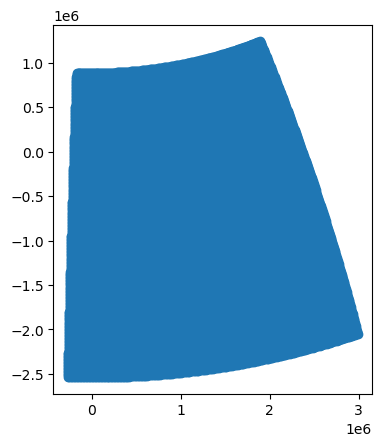

In [26]:
min_long, max_long = all_bat_maps["Long"].min(), all_bat_maps["Long"].max()
min_lat, max_lat = all_bat_maps["Lat"].min(), all_bat_maps["Lat"].max()

lon_coords = np.linspace(min_long - 5, max_long + 5, 200)
lat_coords = np.linspace(min_lat - 5, max_lat + 5, 200)

xy = [{"lon": x, "lat": y, "geometry": Point(x, y)} for x, y in product(lon_coords, lat_coords)]

point_grid = gpd.GeoDataFrame(xy).set_crs(epsg=4326).to_crs(epsg=2163)
point_grid.plot()


# pred_coords = gpd.GeoDataFrame(geometry=gpd.points_from_xy(lon_coords, lat_coords)).set_crs(epsg=4326)
# pred_coords

In [29]:
states = gpd.read_file("./data/data/tl_2024_us_state/tl_2024_us_state.shp")
states_of_interest = [
    "PA",
    "MI",
    "IL",
    "OK",
    "AR",
    "TX",
    "MN",
    "IN",
    "IL",
    "OH",
    "IA",
    "MO",
    "KS",
    "ND",
    "SD",
    "NE",
    "WI",
    "KY",
    "NY",
]
state_df = states[states["STUSPS"].isin(states_of_interest)].to_crs(epsg=2163)

state_df


,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
2,2,3,17,01779784,17,0400000US17,IL,Illinois,00,G4000,A,143778206717,6216848695,+40.1028754,-089.1526108,"POLYGON ((1054020.693 -669765.282, 1053948.636..."
3,2,4,27,00662849,27,0400000US27,MN,Minnesota,00,G4000,A,206244791203,18937236061,+46.3159573,-094.1996043,"POLYGON ((341382.47 454606.093, 341537.561 454..."
15,2,3,55,01779806,55,0400000US55,WI,Wisconsin,00,G4000,A,140294555214,29341156602,+44.6309071,-089.7093916,"POLYGON ((800709.296 188563.637, 800710.405 18..."
17,2,4,31,01779792,31,0400000US31,NE,Nebraska,00,G4000,A,198949953125,1378956981,+41.5433053,-099.8118646,"POLYGON ((338868.218 -392899.6, 338905.863 -39..."
18,1,2,42,01779798,42,0400000US42,PA,Pennsylvania,00,G4000,A,115881476238,3397613881,+40.9046042,-077.8275233,"POLYGON ((2048569.402 -267648.879, 2048562.274..."
24,2,3,39,01085497,39,0400000US39,OH,Ohio,00,G4000,A,105824130554,10274225585,+40.4149297,-082.7119975,"POLYGON ((1619414.341 -262729.837, 1619426.812..."
25,3,7,48,01779801,48,0400000US48,TX,Texas,00,G4000,A,676656702022,19011620342,+31.4347032,-099.2818238,"POLYGON ((145835.431 -1210745.411, 145945.48 -..."
28,3,7,40,01102857,40,0400000US40,OK,Oklahoma,00,G4000,A,177664629521,3373250292,+35.5900815,-097.4867789,"POLYGON ((374876.154 -879503.503, 374943.287 -..."
32,2,4,38,01779797,38,0400000US38,ND,North Dakota,00,G4000,A,178694319927,4414770689,+47.4421740,-100.4608258,"POLYGON ((73005.869 445143.078, 77540.156 4452..."
33,3,6,21,01779786,21,0400000US21,KY,Kentucky,00,G4000,A,102266755818,2384136185,+37.5336844,-085.2929801,"MULTIPOLYGON (((931134.235 -880642.395, 931119..."


In [31]:
prediction_points = point_grid.sjoin(state_df[["geometry"]], how="inner", predicate="within").drop(columns=["index_right"])
prediction_points

# all_water_bodies
# gpd.sjoin_nearest(prediction_points, all_water_bodies, how="left", distance_col="dist_to_water").plot(markersize=0.1)


,lon,lat,geometry
50,-102.566400,29.789758,POINT (-249813.44 -1682646.396)
51,-102.566400,29.945255,POINT (-249379.372 -1665510.143)
52,-102.566400,30.100752,POINT (-248944.082 -1648370.845)
53,-102.566400,30.256249,POINT (-248507.571 -1631228.534)
54,-102.566400,30.411746,POINT (-248069.842 -1614083.241)
...,...,...,...
38522,-72.090906,40.985552,POINT (2288315.084 -51325.711)
38523,-72.090906,41.141050,POINT (2282714.513 -34737.365)
38722,-71.932179,40.985552,POINT (2300687.077 -46839.815)
38723,-71.932179,41.141050,POINT (2295055.183 -30259.483)


In [62]:
joined_grid = gpd.sjoin_nearest(prediction_points, all_water_bodies, how="left", distance_col="water_dist").drop(columns="index_right")
joined_grid = gpd.sjoin(joined_grid, state_df, predicate="within").drop(columns="index_right")

joined_grid[['lon', 'lat', 'geometry', 'water_dist']]

,lon,lat,geometry,water_dist
50,-102.566400,29.789758,POINT (-249813.44 -1682646.396),2022.014820
51,-102.566400,29.945255,POINT (-249379.372 -1665510.143),18423.572543
52,-102.566400,30.100752,POINT (-248944.082 -1648370.845),11691.892073
53,-102.566400,30.256249,POINT (-248507.571 -1631228.534),4631.390537
54,-102.566400,30.411746,POINT (-248069.842 -1614083.241),6505.767717
...,...,...,...,...
38522,-72.090906,40.985552,POINT (2288315.084 -51325.711),753.981482
38523,-72.090906,41.141050,POINT (2282714.513 -34737.365),3973.882963
38722,-71.932179,40.985552,POINT (2300687.077 -46839.815),5358.936294
38723,-71.932179,41.141050,POINT (2295055.183 -30259.483),7103.798885


In [ ]:
big_bodies_of_water = all_water_bodies.sort_values("SQKM", ascending=False).head(10)

lake_points = gpd.sjoin(
    joined_grid,
    big_bodies_of_water,
    how="inner",
    predicate="intersects",
).index

prediction_grid = joined_grid.loc[joined_grid.index.difference(lake_points)][["lon", "lat", "geometry", "water_dist"]].to_crs(epsg=4326)

if False:
    prediction_grid.to_csv("./data/data/prediction_grid.csv", index=False)

<Axes: >

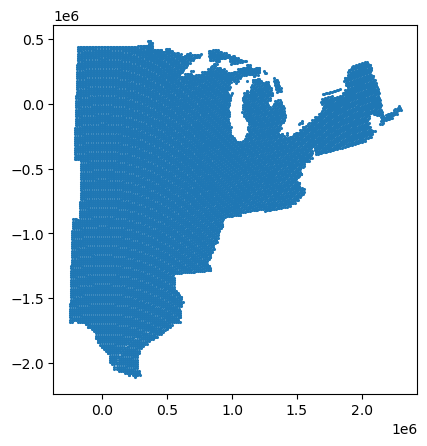

In [65]:
prediction_grid.plot(markersize=1.50)

In [45]:
prediction_grid.columns

Index(['lon', 'lat', 'geometry', 'REGION', 'DIVISION', 'STATEFP', 'STATENS',
       'GEOID', 'GEOIDFQ', 'STUSPS', 'NAME', 'LSAD', 'MTFCC', 'FUNCSTAT',
       'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON'],
      dtype='object')